In [1]:
# Imports
import sys
import json

import torchinfo
import torch
import torch.nn as nn

import seqpro as sp
import seqdata as sd

# Import the code for loading the PyTorch model
sys.path.append('/cellar/users/aklie/opt/ml4gland/basenji2-pytorch')
from basenji2_pytorch import Basenji2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Model

In [2]:
# Params for model
params = "/cellar/users/aklie/data/datasets/ENCODE_examples/bin/model_training/2048bp-input_to_32bp-bins_params.json"

# Open up the model config file
with open(params) as params_open:
    params_load = json.load(params_open)
    model_params = params_load['model']
    train_params = params_load['train']

# Create the model
basenji2 = Basenji2(model_params)

# Summarize
torchinfo.summary(basenji2, input_size=(1, 4, 2048), depth=5)

Layer (type:depth-idx)                                            Output Shape              Param #
Basenji2                                                          [1, 16, 1]                --
├─Sequential: 1-1                                                 [1, 16, 1]                --
│    └─Sequential: 2-1                                            [1, 1536, 16]             --
│    │    └─BasenjiConvBlock: 3-1                                 [1, 288, 1024]            --
│    │    │    └─Sequential: 4-1                                  [1, 288, 1024]            --
│    │    │    │    └─GELU: 5-1                                   [1, 4, 2048]              --
│    │    │    │    └─Conv1d: 5-2                                 [1, 288, 2048]            17,280
│    │    │    │    └─BatchNorm1d: 5-3                            [1, 288, 2048]            576
│    │    │    │    └─KerasMaxPool1d: 5-4                         [1, 288, 1024]            --
│    │    └─BasenjiConvTower: 3-2       

# Data

In [3]:
# Load data
sdata = sd.open_zarr("/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2023_12_30/ATAC-seq/GM21381/GM21381.zarr").load()

# One-hot encode the sequence and make it a PyTorch tensor
ohe_seqs = torch.tensor(sp.ohe(sdata["seq"].values, alphabet=sp.alphabets.DNA), dtype=torch.float32).permute(0, 2, 1)

# Bin the coverage
cov = sdata["cov"].values
bin_cov = sp.bin_coverage(cov, bin_width=128, length_axis=2)

# Get targets
targets = torch.tensor(bin_cov, dtype=torch.float32).permute(0, 2, 1).squeeze(-1)

# Print shapes
ohe_seqs.shape, targets.shape

(torch.Size([95590, 4, 2048]), torch.Size([95590, 16]))

In [4]:
# Create the data loader, ohe_seqs are inputs, targets are outputs
batch_size = 128
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(ohe_seqs, targets),
    batch_size=batch_size,
    shuffle=True,
)

In [5]:
batch = next(iter(data_loader))
batch[0].shape, batch[1].shape

(torch.Size([128, 4, 2048]), torch.Size([128, 16]))

# Test predictions

In [27]:
# Loss function
loss_fn = nn.PoissonNLLLoss(log_input=False, full=True)

In [7]:
preds = basenji2(batch[0].cuda()).squeeze(-1)
preds.shape

torch.Size([128, 16])

In [29]:
loss_fn(preds, targets[128:256].to('cuda'))

tensor(150.8730, device='cuda:0', grad_fn=<MeanBackward0>)

In [10]:
# For each batch, compute the loss and print every 10 batches
for i, (x, y) in enumerate(data_loader):
    x = x.cuda()
    y = y.cuda()
    preds = basenji2(x).squeeze(-1)
    loss = loss_fn(preds, y)
    if i % 10 == 0:
        print(i, loss.item())
    if i == 100:
        break

0 19.418781280517578
10 14.905661582946777
20 17.45621109008789
30 15.810864448547363
40 19.263273239135742
50 17.63465690612793
60 17.779325485229492
70 15.828573226928711
80 13.9569730758667
90 19.07834815979004
100 18.03013801574707


In [11]:
import torch.optim as optim
from tqdm import tqdm

In [30]:
# Training loop

# Move the model to the GPU
basenji2.to('cuda').train()

# Create the optimizer
optimizer = optim.Adam(basenji2.parameters(), lr=train_params['learning_rate'])

# Create the progress bar
pbar = tqdm(range(10))

# Loop over epochs
for epoch in pbar:

    # Loop over batches
    for i, (x, y) in enumerate(data_loader):

        # Move to GPU
        x = x.cuda()
        y = y.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        preds = basenji2(x).squeeze(-1)

        # Compute the loss
        loss = loss_fn(preds, y)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update the progress bar
        pbar.set_description(f"Epoch {epoch} Loss {loss.item():.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Loss 9.3264:  20%|██        | 2/10 [06:58<27:53, 209.25s/it] 


KeyboardInterrupt: 

In [31]:
# Clear cache
torch.cuda.empty_cache()
import gc
gc.collect()

475

In [32]:
basenji2.eval()

Basenji2(
  (model): Sequential(
    (trunk): Sequential(
      (0): BasenjiConvBlock(
        (block): Sequential(
          (0): GELU(approximate='none')
          (1): Conv1d(4, 288, kernel_size=(15,), stride=(1,), padding=same, bias=False)
          (2): BatchNorm1d(288, eps=0.001, momentum=0.09999999999999998, affine=True, track_running_stats=True)
          (3): KerasMaxPool1d(
            (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          )
        )
      )
      (1): BasenjiConvTower(
        (tower): Sequential(
          (0): BasenjiConvBlock(
            (block): Sequential(
              (0): GELU(approximate='none')
              (1): Conv1d(288, 339, kernel_size=(5,), stride=(1,), padding=same, bias=False)
              (2): BatchNorm1d(339, eps=0.001, momentum=0.09999999999999998, affine=True, track_running_stats=True)
              (3): KerasMaxPool1d(
                (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilati

In [33]:
preds = basenji2(ohe_seqs[:128].cuda()).squeeze(-1)

In [34]:
from scipy.stats import pearsonr

In [35]:
# Compute the Pearson correlation coefficient for each of the 128 examples individually
pearsons = [pearsonr(preds[i].cpu().detach().numpy(), targets[i].cpu().detach().numpy())[0] for i in range(128)]
pearsons

[0.7890441827261973,
 0.9103718088256418,
 0.9236318869397329,
 0.8937350378757364,
 0.9205722439326689,
 0.8253128750049354,
 0.5761652171582458,
 0.885118626972784,
 0.9196594435736818,
 0.8638988420813307,
 0.8244106261174616,
 0.8555587317434261,
 0.8369302904707853,
 0.8226796944491319,
 0.8663655035929545,
 0.894080416629766,
 0.7772023850619825,
 0.8422807781334862,
 0.883729168617497,
 0.7427650716253482,
 0.8770461919434874,
 0.8276517501850453,
 0.985560776420605,
 0.8770461919434874,
 0.8843834453505742,
 0.8588979708979658,
 0.904523523453655,
 0.8338989293983197,
 0.8100640958520783,
 0.8584040568817994,
 0.762375634785704,
 0.8607236833307753,
 0.8956220956479711,
 0.9210445780036247,
 0.9218433295882982,
 0.7696751145117956,
 0.8854582407407775,
 0.8445935813808274,
 0.8994886868766576,
 0.9776956867194446,
 0.9327238399286686,
 0.9140259842713485,
 0.8573944524933246,
 0.8836523814411741,
 0.8217436155285175,
 0.8304922461175098,
 0.9172537048775278,
 0.870127807678154,

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_tracks(tracks, interval, height=1.5, colors=None):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [37]:
sdata[["chrom", "chromStart", "chromEnd"]].to_dataframe().iloc[0]

chrom              chr5
chromStart    146202569
chromEnd      146204617
Name: 0, dtype: object

In [38]:
# Plot signal and control
chrom = "chr5"
chromStart = 146202569
chromEnd = 146204617
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)

In [39]:
bin_cov[0]

array([[ 13.,   6.,   3.,  32.,  57., 127., 633., 822., 281., 156.,  64.,
         55.,   9.,  14.,   7.,  25.]], dtype=float32)

In [40]:
bin_cov[0].shape

(1, 16)

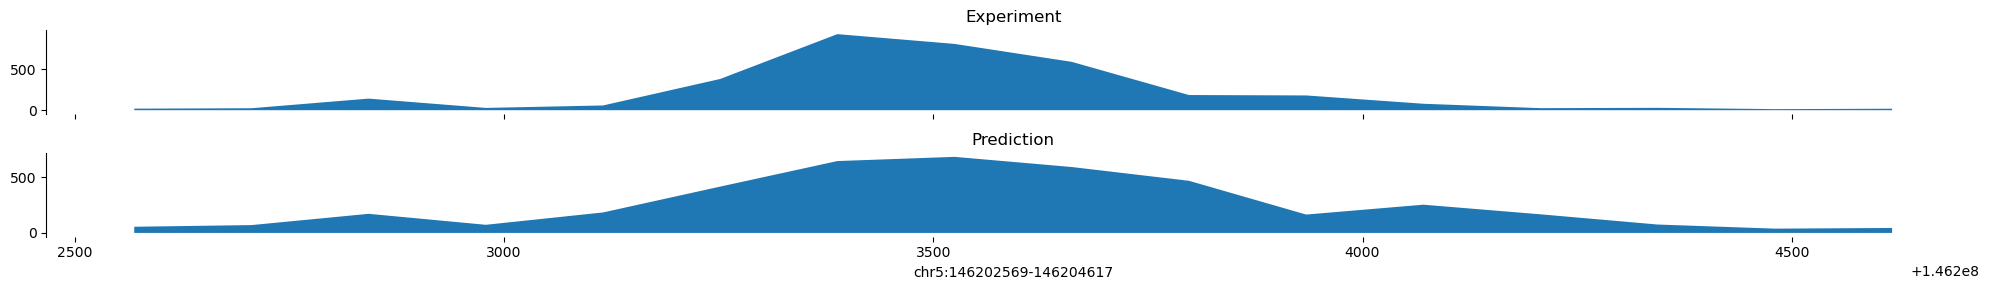

In [43]:
# Plot tracks
plot_tracks({
    "Experiment": bin_cov[2].squeeze(0),
    "Prediction": preds[2].cpu().detach().numpy()
    }, 
    interval
)

In [ ]:
batch = next(iter(data_loader))
x, y = batch
basenji2(x.to('cuda')).shape, y.shape
loss_fn(basenji2(x.to('cuda')), y.to('cuda'))